Same model, randomised. We know that the values for the variables follow a uniform distribution between 0 and 1, and the data that we see are the product of multiplication of each factor by this Protein,Carbohydrats and Fats value. Then we make a guess of what distribution do the parameters follow, an ubiased guess would be that they follow a normal(1,100). Then the ATP is the deterministic variable in the model, because it is determined by the other three.
The error can be a normal with mean 0 and std 10.

We assign observed data to P,C,F and ATP, se we have to assign determinitic values to these.

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/arturo/.local/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv("diet_and_atp.tsv", header=[0], sep="\t")
P = data["Protein"]
C = data["Carbohydrates"]
F = data["Fat"]
A = data["ATP"]

In [3]:
with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    p = pm.Normal("p", mu = 1, sd = 100)
    c = pm.Normal("c", mu = 1, sd = 100)
    f = pm.Normal("f", mu = 1, sd = 100) 

    atp = pm.Normal("ATP", mu = p*P+c*C+f*F, sigma = std, observed = data["ATP"])
    
    trace = pm.sample(10000, step=pm.Metropolis()) #aquí exploramos el modelo con el algoritmo de metropolis
    burned_trace = trace[2000:]  


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [f]
>Metropolis: [c]
>Metropolis: [p]
>Metropolis: [std]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [12:51<00:00, 27.22draws/s]
The number of effective samples is smaller than 10% for some parameters.


/home/arturo/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/arturo/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/arturo/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5b80e3390>,
      dtype=object)

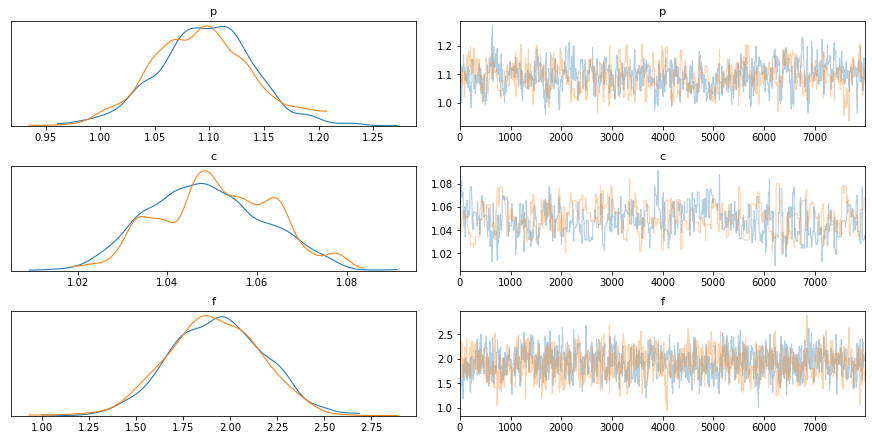

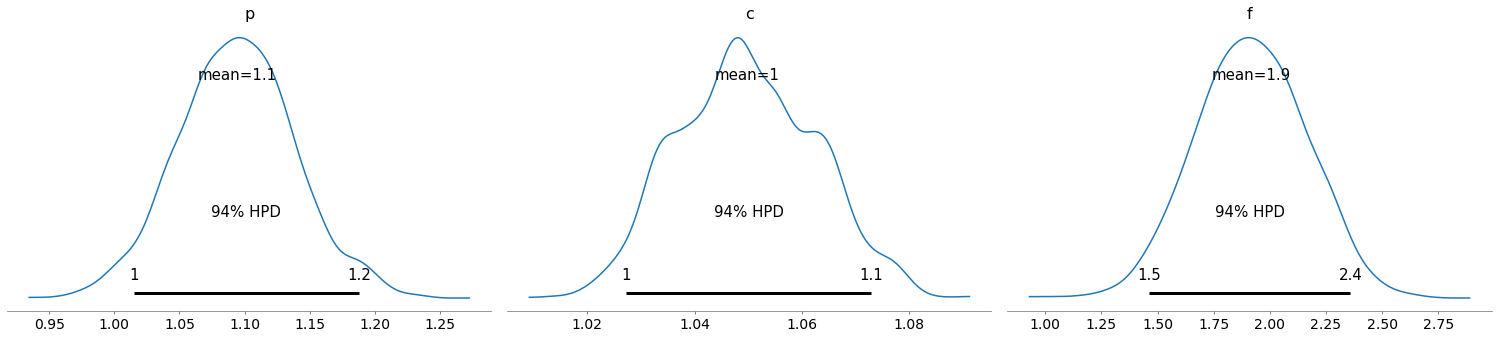

In [4]:
pm.plots.traceplot(burned_trace, var_names=["p", "c", "f"])
pm.plot_posterior(data=burned_trace, var_names=["p", "c", "f"])